In [161]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import robust_scale
from sklearn import preprocessing
from scipy.sparse.linalg import svds
from sklearn.manifold import TSNE
from adjustText import adjust_text
%matplotlib inline

In [199]:
fund_stat = pd.read_excel("fund_name_risk.xlsx")

In [200]:
fund_stat["std"].mean()

0.06646084326054935

In [201]:
# fill nan with mean
fund_stat["std"][fund_stat["std"]==0] = fund_stat["std"].mean()

c:\users\thtang\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [202]:
# fund_stat_clean = fund_stat[fund_stat["std"] != 0].reset_index(drop=True)

In [205]:
fund_std_dict = {}
for index, row in fund_stat.iterrows():
    fund_std_dict[row["name"]] = row["std"]

# load invest data

In [49]:
invest = pd.read_excel("invest_data.xlsx")
invest.shape

(5820, 5)

In [50]:
invest_clean = invest[invest["金額"] != 0].reset_index(drop=True)

In [51]:
invest_clean.shape

(5146, 5)

In [53]:
max_ans_dict = pickle.load(open("./max_ans_dict.pkl","rb"))
uid_feature_dict = pickle.load(open("./uid_feature_dict.pkl","rb"))

In [54]:
quest_feautre_name = [q_id + "_" + str(n+1)for q_id in max_ans_dict.keys() for n in range(max_ans_dict[q_id])]
print("number of features:", len(quest_feautre_name))

number of features: 121


In [55]:
feature_matrix = []
for index, row in invest_clean.iterrows():
    uid = row["客戶"]
    feature_matrix.append(uid_feature_dict[uid])

In [56]:
feature_df = pd.DataFrame(feature_matrix)
feature_df.columns = quest_feautre_name

In [63]:
merge_df = pd.concat([invest_clean, feature_df],
                     sort=False, 
                     ignore_index=True, axis=1,
                    )
merge_df.columns = list(invest_clean.columns) + list(feature_df.columns)

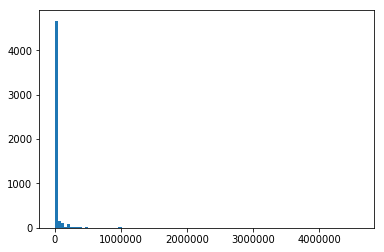

In [75]:
plt.hist(merge_df["金額"], bins=100)
plt.show()

In [98]:
merge_df.to_csv("./data_df.csv", index=False, encoding="big5")

In [ ]:
# (todo) create real value gound truth

def softmax(x):
    exp_x = np.exp(x)
    softmax_x = exp_x / np.sum(exp_x)
    return softmax_x 

amount = np.array(merge_df["金額"]).reshape(len(merge_df["金額"]),1)

robust_scale(amount).flatten().min()

softmax(robust_scale(amount).flatten()


# create user_item interaction matrix

In [116]:
item_le = preprocessing.LabelEncoder()
fund_encoding = item_le.fit_transform(merge_df["基金簡稱"])
merge_df["item_id"] = fund_encoding

user_le = preprocessing.LabelEncoder()
user_encoding = user_le.fit_transform(merge_df["客戶"])
merge_df["user_id"] = user_encoding

In [129]:
# create user_item matrix
interaction_matrix = np.zeros((len(user_le.classes_),len(item_le.classes_)))
print("matrix size:", interaction_matrix.shape)

matrix size: (1462, 83)


In [132]:
for index, row in merge_df.iterrows():
    item_index = merge_df["item_id"]
    user_index = merge_df["user_id"]
    interaction_matrix[user_index, item_index] = 1

# SVD

In [135]:
latent = 50 # rank
U, Sigma, Vt = svds(interaction_matrix, k=latent)

### visualization 

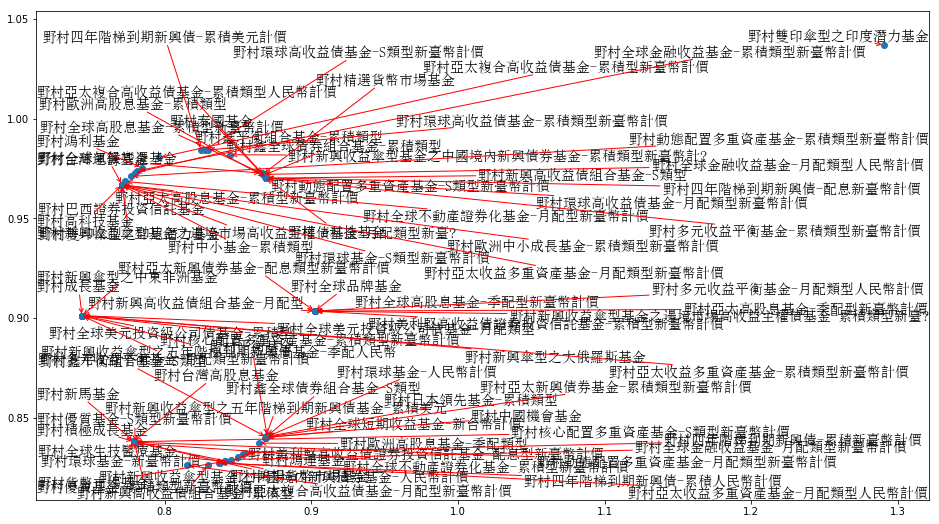

In [175]:
from matplotlib.font_manager import FontProperties # 步驟一
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=14) # 步驟二

tsne = TSNE(n_components=2, random_state=0, perplexity=99)
vis_data = tsne.fit_transform(Vt.T)

plt.figure(figsize=(16,9))
# cm = plt.cm.get_cmap("tab20", 18)
sc = plt.scatter(vis_data[:,0], vis_data[:,1])
texts = [plt.text(vis_data[:,0][i], vis_data[:,1][i], 
                  words, ha='center', va='center', fontproperties=font) 
         for i, words in enumerate(item_le.classes_)]
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
# plt.colorbar(ticks=range(18))
# plt.clim(-0.5, 17.5)
# plt.xlim(-40,40)
# plt.ylim(-40,40)
plt.show()

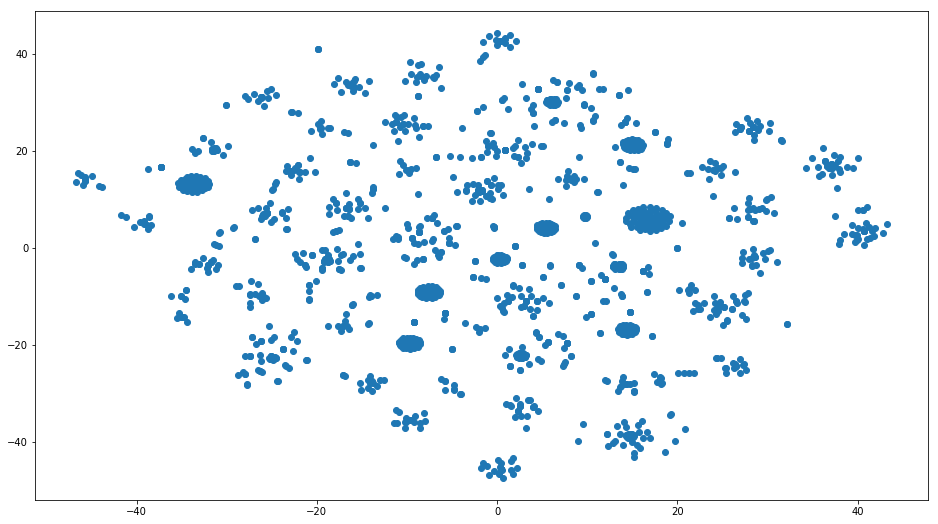

In [176]:
# (todo) 挑特徵上色
tsne = TSNE(n_components=2, random_state=0, perplexity=30)
vis_data = tsne.fit_transform(U)

plt.figure(figsize=(16,9))
# cm = plt.cm.get_cmap("tab20", 18)
sc = plt.scatter(vis_data[:,0], vis_data[:,1])
# plt.colorbar(ticks=range(18))
# plt.clim(-0.5, 17.5)
# plt.xlim(-40,40)
# plt.ylim(-40,40)
plt.show()

# feature importance

add standardivation

In [208]:
std_list = []
for name in merge_df["基金簡稱"]:
    std_list.append(fund_std_dict[name])

In [211]:
merge_df["fund_std"] = std_list

計算每個 user 投資標的的平均 std

In [216]:
merge_df_user_group_mean = merge_df.groupby('客戶',as_index=False, sort=False).mean()
merge_df_user_group_mean

,客戶,金額,A0_1,A0_2,A0_3,A01_1,A01_2,A01_3,A01_4,A01_5,...,B06_4,B06_5,B07_1,B07_2,B07_3,B07_4,B07_5,item_id,user_id,fund_std
0,100066,46264.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,18.692308,183.0,0.101891
1,100542,3000.000000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,64.000000,184.0,0.118306
2,100558,4000.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.333333,185.0,0.170087
3,100606,3000.000000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,28.000000,186.0,0.126399
4,100657,5000.000000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,27.000000,187.0,0.112105
5,101140,14066.352941,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,30.352941,188.0,0.104128
6,105582,232249.285714,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,27.857143,206.0,0.071614
7,123855,121149.200000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,33.400000,229.0,0.132302
8,101150,35153.500000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,41.400000,189.0,0.098339
9,101275,12857.142857,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,34.428571,190.0,0.154550


In [218]:
x, y = merge_df_user_group_mean["金額"], merge_df_user_group_mean["fund_std"]

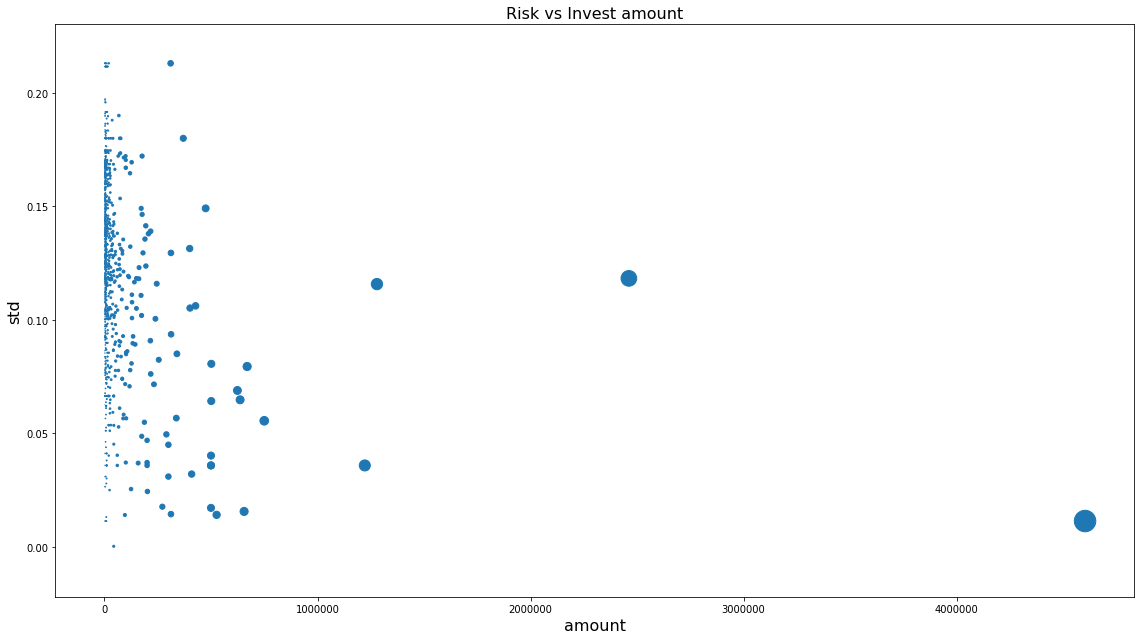

In [234]:
plt.figure(figsize=(16,9))
# s = [20*4**n for amount in x]
# cm = plt.cm.get_cmap("tab20", 18)
sc = plt.scatter(x, y, s=x/10000)
plt.title("Risk vs Invest amount", fontsize=16)
plt.xlabel("amount", fontsize=16)
plt.ylabel("std", fontsize=16)
plt.tight_layout()
plt.savefig("risk_amount.png", dpi=300)
plt.show()